In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
from numba import njit
from scipy.stats import median_abs_deviation

import bayesflow as bf
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

import sys
sys.path.append("../assets/")
from priors import sample_gamma, sample_eta, sample_random_walk
from likelihood import sample_non_stationary_diffusion_process
from context import generate_context
from configurations import approximator_settings    

## Model

$$
\begin{align}
x &\sim wiener(v_t, a_t, \tau_t, \beta) \\
v_t &= v_0 + b_{v, t} * \text{validity} \\
b_{v, t} &= \mathcal{T}(b_{v, 0:t-1}, \eta_v, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, \eta_v) \\
a_t &= \mathcal{T}(a_{0:t-1}, \eta_a, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, \eta_a) \\
\tau_t &= \tau_{0, t} + b_{\tau} * \text{face context} \\
\tau_{0, t} &= \mathcal{T}(\tau_{0, 0:t-1}, \eta_{\tau}, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, {\tau}) \\

\end{align}
$$


In [ ]:
# scaled sigmod 
# prior predictive check accuracy plot
# remove base drift

### Parameter overview

**Global parameters $\eta$ (Static transition model parameters)**

$\eta = \{\eta_v, \eta_a, \eta_{\tau}\}$

**Local parameters $\theta_{1:T}$ (Time-varying DDM parameters)**

$\theta_{1:T} = \{b_{v, 1:T},  a_{1:T}, \tau_{1:T}\}$

**Shared parameters $\gamma$ (Static DDM parameters)**

$\gamma = \{v_0,  b_{\tau}, \beta\}$

## Constants

In [2]:
TRAIN_NETWORK = False
FIT_MODEL = False

In [3]:
NUM_OBS = 246
NUM_SAMPLES = 2000
NUM_RESIMULATIONS = 500

LOCAL_PARAM_LABELS = [
    'Sensitivity', 'Threshold', 'Non-decision time',
]
LOCAL_PARAM_NAMES  = [
    r'b_v', r'a', r'\tau_0'
]

GLOBAL_PARAM_LABELS = [
    'Baseline drift', 'Effect on NDT', 'Bias',
]
GLOBAL_PARAM_NAMES  = [
    r'$v_0$', r'$b_{\tau}$', r'$\beta$'
]

FONT_SIZE_1 = 28
FONT_SIZE_2 = 26
FONT_SIZE_3 = 24
FONT_SIZE_4 = 22


In [4]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Exemplar parameter trajectory

In [5]:
eta = sample_eta()
theta_t = sample_random_walk(eta)

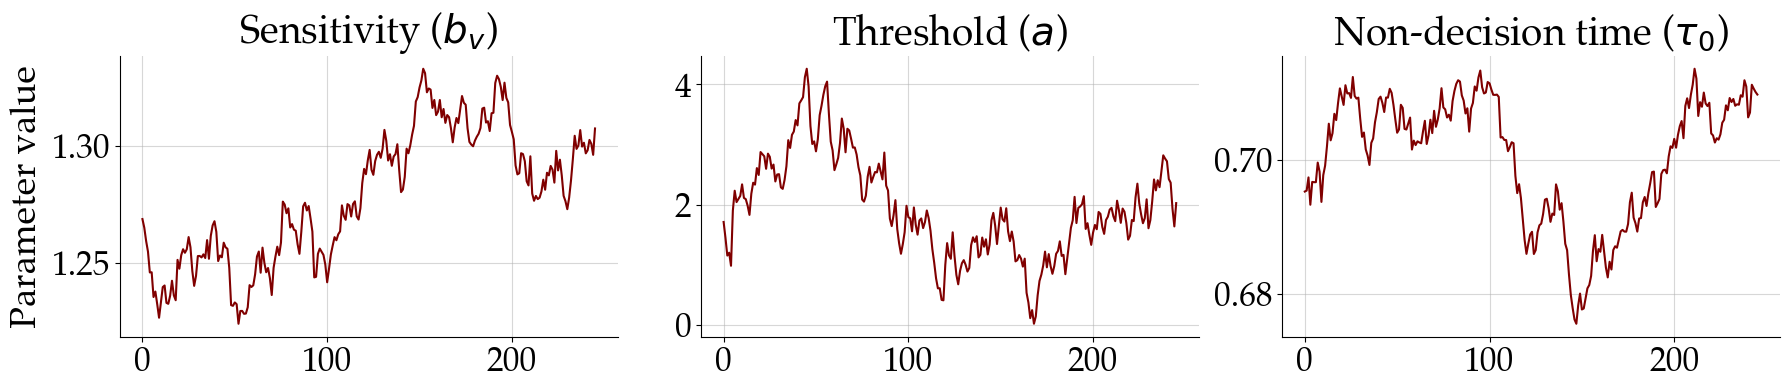

In [6]:
time = np.arange(theta_t.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_t[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    if i > 3:
        ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

In [7]:
prior = bf.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
    shared_prior_fun=sample_gamma
    )

context = bf.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
    )

likelihood = bf.simulation.Simulator(
    simulator_fun=sample_non_stationary_diffusion_process,
    context_generator=context,
    )

model = bf.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="random_walk_diffusion_model",
)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 246, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 246, 2)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 246, 3)
INFO:root:Shape of shared_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


## Configurator

In [9]:
# N = 50000
# prior_samples = prior(N)

In [10]:
# HYPER_PRIOR_MEAN = np.round(prior_samples['hyper_parameters'].mean(axis=0), 2)
# HYPER_PRIOR_STD = np.round(prior_samples['hyper_parameters'].std(axis=0), 2)

# local_samples = prior_samples['local_parameters'].reshape(-1, prior_samples['local_parameters'].shape[-1])
# LOCAL_PRIOR_MEAN = np.round(local_samples.mean(axis=0), 2)
# LOCAL_PRIOR_STD = np.round(local_samples.std(axis=0), 2)

In [15]:
def configure_input(raw_dict):
    # prepare data
    data = raw_dict.get("sim_data")
    truth_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 0][:, :, None]
    face_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 1][:, :, None]
    validity_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 2][:, :, None]
    summary_conditions = np.c_[data, truth_context, to_categorical(face_context), validity_context]

    theta_t = raw_dict.get("local_prior_draws")
    eta = raw_dict.get("hyper_prior_draws")
    gamma = raw_dict.get("shared_prior_draws")

    # out_dict = dict(
    #     local_parameters=((theta_t - LOCAL_PRIOR_MEAN) / LOCAL_PRIOR_STD).astype(np.float32),
    #     hyper_parameters=((eta - HYPER_PRIOR_MEAN) / HYPER_PRIOR_STD).astype(np.float32),
    #     summary_conditions=summary_conditions.astype(np.float32),
    # )
    out_dict = dict(
        local_parameters=theta_t.astype(np.float32),
        hyper_parameters=eta.astype(np.float32),
        shared_parameters=gamma.astype(np.float32),
        summary_conditions=summary_conditions.astype(np.float32),
    )
    return out_dict

# Neural Approximator

In [16]:
summary_network = bf.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [17]:
local_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=3,
        **approximator_settings.get("local_amortizer_settings")
    )
)

global_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=3+3,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [18]:
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/model_3"
)

INFO:root:Loaded loss history from ../checkpoints/model_3/history_100.pkl.
INFO:root:Networks loaded from ../checkpoints/model_3/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

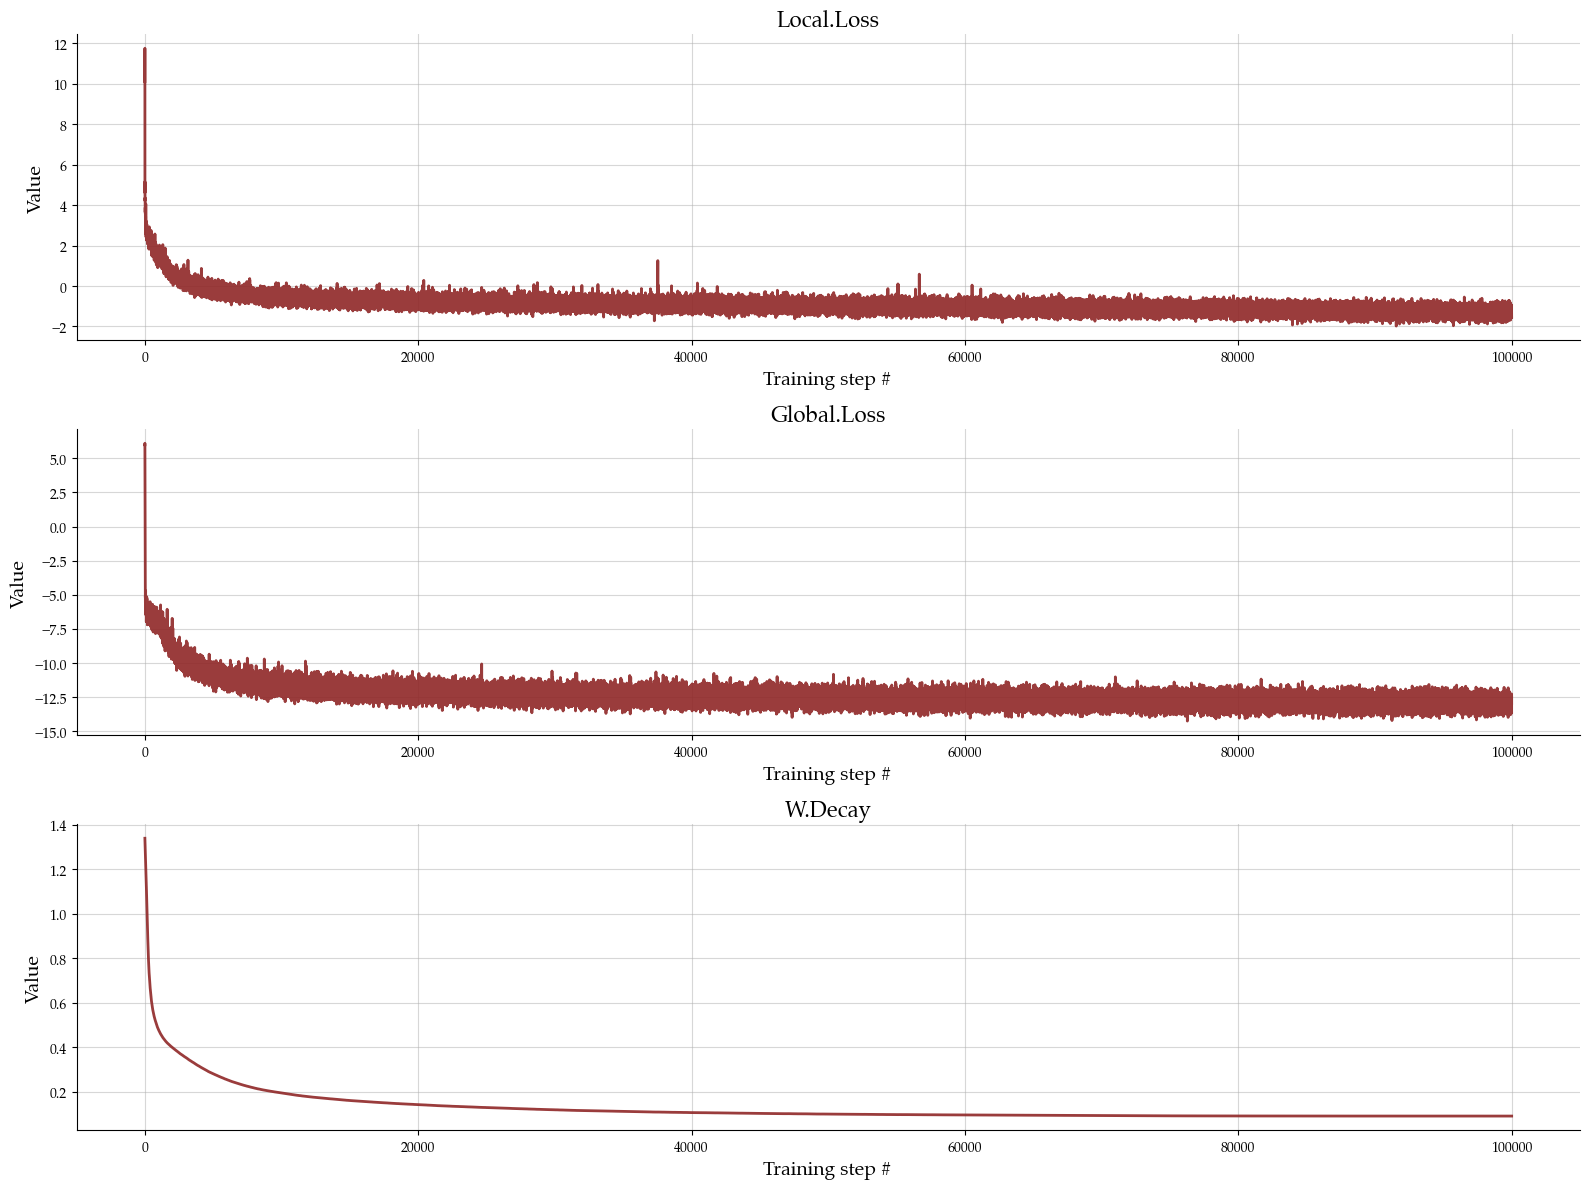

In [19]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=100,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())

# Validation

# Application

## Fit to Empirical Data

In [20]:
data = pd.read_csv('../data/prepared_data.csv')
SUBJECTS = data.id.unique()
NUM_SUBJECTS = len(SUBJECTS)

In [21]:
if FIT_MODEL:
    local_post_samples = np.full((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3), np.nan)
    global_post_samples = np.full((NUM_SUBJECTS, NUM_SAMPLES, 6), np.nan)

    resim_data = np.full((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS, 7), np.nan)

    for i, id in enumerate(tqdm(SUBJECTS)):
        # model fitting
        person_data = data.loc[data.id == id]

        truth_context = person_data.correct_resp
        face_context = person_data.number_faces
        validity_context = person_data.validity

        resp = person_data.resp
        rt = person_data.rt
        mask = np.isfinite(rt)

        data_configured = np.c_[
            rt[mask], resp[mask], truth_context[mask],
            to_categorical(face_context[mask]), validity_context[mask]
        ][None, :, :].astype(np.float32)

        post_samples = amortizer.sample({'summary_conditions': data_configured}, n_samples=NUM_SAMPLES)

        local_post_samples[i, mask] = post_samples['local_samples']
        global_post_samples[i] = post_samples['global_samples']

        # posterior resimulation
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        local_samples = post_samples['local_samples'][:, idx].astype(np.float32)
        global_samples = post_samples['global_samples'][idx, -3:].astype(np.float32)
        context = np.c_[truth_context[mask], face_context[mask], validity_context[mask]].astype(np.float32)
        sub_id = np.full((NUM_RESIMULATIONS, NUM_OBS), id)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS))
        for j in range(NUM_RESIMULATIONS):
            x = sample_non_stationary_diffusion_process([local_samples[:, j], global_samples[j]], context)
            resim_data[i, j, mask, 2:] = np.c_[x, context]
        resim_data[i, :, :, 0] = sub_id
        resim_data[i, :, :, 1] = sim_seq

    np.save("../data/local_post_samples.npy", local_post_samples)
    np.save("../data/global_post_samples.npy", global_post_samples)
    np.save("../data/post_resim_data.npy", resim_data)
else:
    local_post_samples = np.load("../data/local_post_samples.npy")
    global_post_samples = np.load("../data/global_post_samples.npy")
    post_resim_data = np.load("../data/post_resim_data.npy")

## Parameter Trajectory

In [22]:
exp1_congruent_ids = data.id.loc[(data.exp == 1) & (data.condition == "congruent")].unique()
exp1_incongruent_ids = data.id.loc[(data.exp == 1) & (data.condition == "incongruent")].unique()
exp2_witness_congruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "congruent") & (data.exp_type == "witness")].unique()
exp2_witness_incongruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "incongruent") & (data.exp_type == "witness")].unique()
exp2_gambling_congruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "congruent") & (data.exp_type == "gambling")].unique()
exp2_gambling_incongruent_ids = data.id.loc[(data.exp == 2) & (data.condition == "incongruent") & (data.exp_type == "gambling")].unique()

ids_per_condition = [
    exp1_congruent_ids, exp1_incongruent_ids,
    exp2_witness_congruent_ids, exp2_witness_incongruent_ids,
    exp2_gambling_congruent_ids, exp2_gambling_incongruent_ids
]

CONDITION_NAMES = [
    "Experiment 1 (witness)",
    "Experiment 2 (witness)",
    "Experiment 2 (gambling)"
]

local_post_per_condition = [
    local_post_samples[exp1_congruent_ids], local_post_samples[exp1_incongruent_ids],
    local_post_samples[exp2_witness_congruent_ids], local_post_samples[exp2_witness_incongruent_ids],
    local_post_samples[exp2_gambling_congruent_ids], local_post_samples[exp2_gambling_incongruent_ids]
]

shared_post_per_condition = [
    global_post_samples[exp1_congruent_ids, :, -3:], global_post_samples[exp1_incongruent_ids, :, -3:],
    global_post_samples[exp2_witness_congruent_ids, :, -3:], global_post_samples[exp2_witness_incongruent_ids, :, -3:],
    global_post_samples[exp2_gambling_congruent_ids, :, -3:], global_post_samples[exp2_gambling_incongruent_ids, :, -3:]
]

pred_data_per_condition = [
    post_resim_data[exp1_congruent_ids], post_resim_data[exp1_incongruent_ids], 
    post_resim_data[exp2_witness_congruent_ids], post_resim_data[exp2_witness_incongruent_ids], 
    post_resim_data[exp2_gambling_congruent_ids], post_resim_data[exp2_gambling_incongruent_ids],
]

In [ ]:
# emp_data = np.full((NUM_SUBJECTS, NUM_OBS, 2), np.nan)
# for i in range(NUM_SUBJECTS):
#     person_data = data.loc[data.id == id]
#     rt = person_data.rt
#     correct = person_data.correct
#     mask = np.isfinite(rt)
#     emp_data[i, mask] = np.c_[rt[mask], correct[mask]]

# emp_data_per_condition = [
#     emp_data[exp1_congruent_ids], emp_data[exp1_incongruent_ids],
#     emp_data[exp2_witness_congruent_ids], emp_data[exp2_witness_incongruent_ids],
#     emp_data[exp2_gambling_congruent_ids], emp_data[exp2_gambling_incongruent_ids]
# ]

In [23]:
local_summary_per_condition = []
for i in range(len(local_post_per_condition)):
    local_means = np.nanmean(np.nanmedian(local_post_per_condition[i], axis=2), axis=0)
    local_stds = np.nanstd(np.nanmedian(local_post_per_condition[i], axis=2), axis=0)
    local_summary_per_condition.append(
        np.c_[local_means[:, :, None], local_stds[:, :, None]]
    )

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_80006/2318967624.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


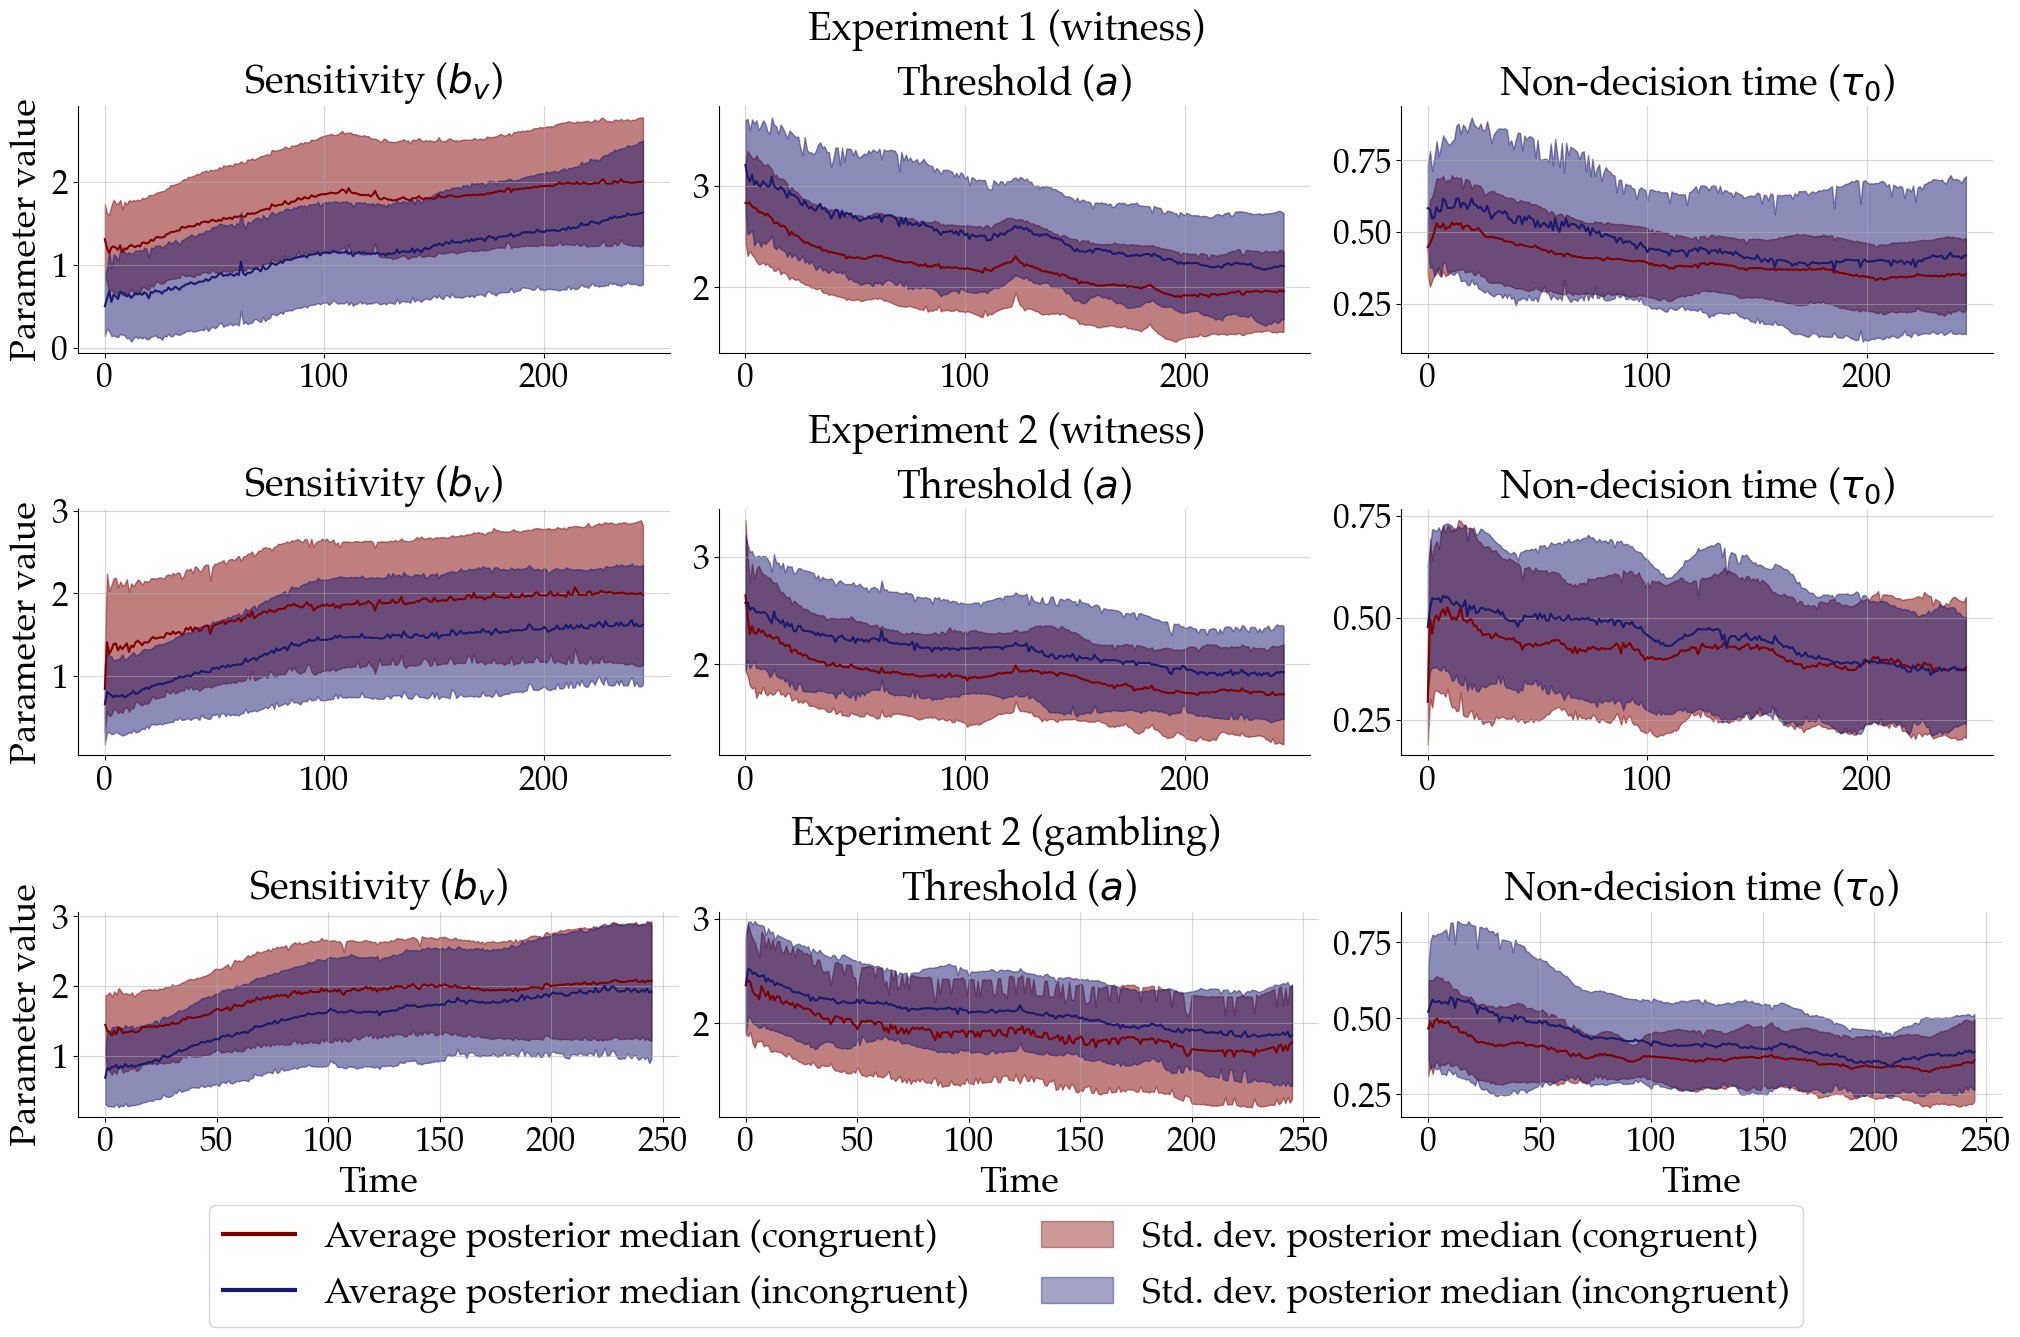

In [24]:
time = np.arange(local_summary_per_condition[0].shape[0])
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
# create 4x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1, fontweight='bold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot(
            time, local_summary_per_condition[2*row][:, col, 0],
            color = "maroon", label = 'Average posterior median (congruent)'
        )
        
        ax.fill_between(
            time,
            local_summary_per_condition[2*row][:, col, 0] - local_summary_per_condition[2*row][:, col, 1],
            local_summary_per_condition[2*row][:, col, 0] + local_summary_per_condition[2*row][:, col, 1],
            alpha = 0.5,
            color = "maroon",
            label = "Std. dev. posterior median (congruent)"
        )
        ax.plot(
            time, local_summary_per_condition[2*row+1][:, col, 0],
            color = 'midnightblue', label = 'Average posterior median (incongruent)'
        )
        
        ax.fill_between(
            time,
            local_summary_per_condition[2*row+1][:, col, 0] - local_summary_per_condition[2*row+1][:, col, 1],
            local_summary_per_condition[2*row+1][:, col, 0] + local_summary_per_condition[2*row+1][:, col, 1],
            alpha = 0.5,
            color = 'midnightblue',
            label = "Std. dev. posterior median (incongruent)"
        )
        ax.grid(alpha=0.5)

        ax.set_title(f'{LOCAL_PARAM_LABELS[col]} (${LOCAL_PARAM_NAMES[col]}$)', fontsize=FONT_SIZE_1)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        if col == 0:
            ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        if row == 2:
            ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

handles = [
    Line2D(
        xdata=[], ydata=[], markersize=10, lw=3,
        color='maroon', label='Average posterior median (congruent)'
    ),
    Line2D(
        xdata=[], ydata=[], markersize=10, lw=3,
        color='midnightblue', label='Average posterior median (incongruent)'
    ),
    Patch(
        color='maroon', label='Average posterior median (congruent)', alpha=0.4
    ),
    Patch(
        color='midnightblue', label='Average posterior median (incongruent)', alpha=0.4
    )
]

fig.subplots_adjust(hspace=0.5)
fig.legend(
    handles,
    ['Average posterior median (congruent)', 'Average posterior median (incongruent)',
    'Std. dev. posterior median (congruent)', 'Std. dev. posterior median (incongruent)'],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
    loc="center", ncol=2
)

sns.despine()
fig.savefig("../plots/average_param_trajectory.pdf", dpi=300, bbox_inches="tight")

## Shared Parameters

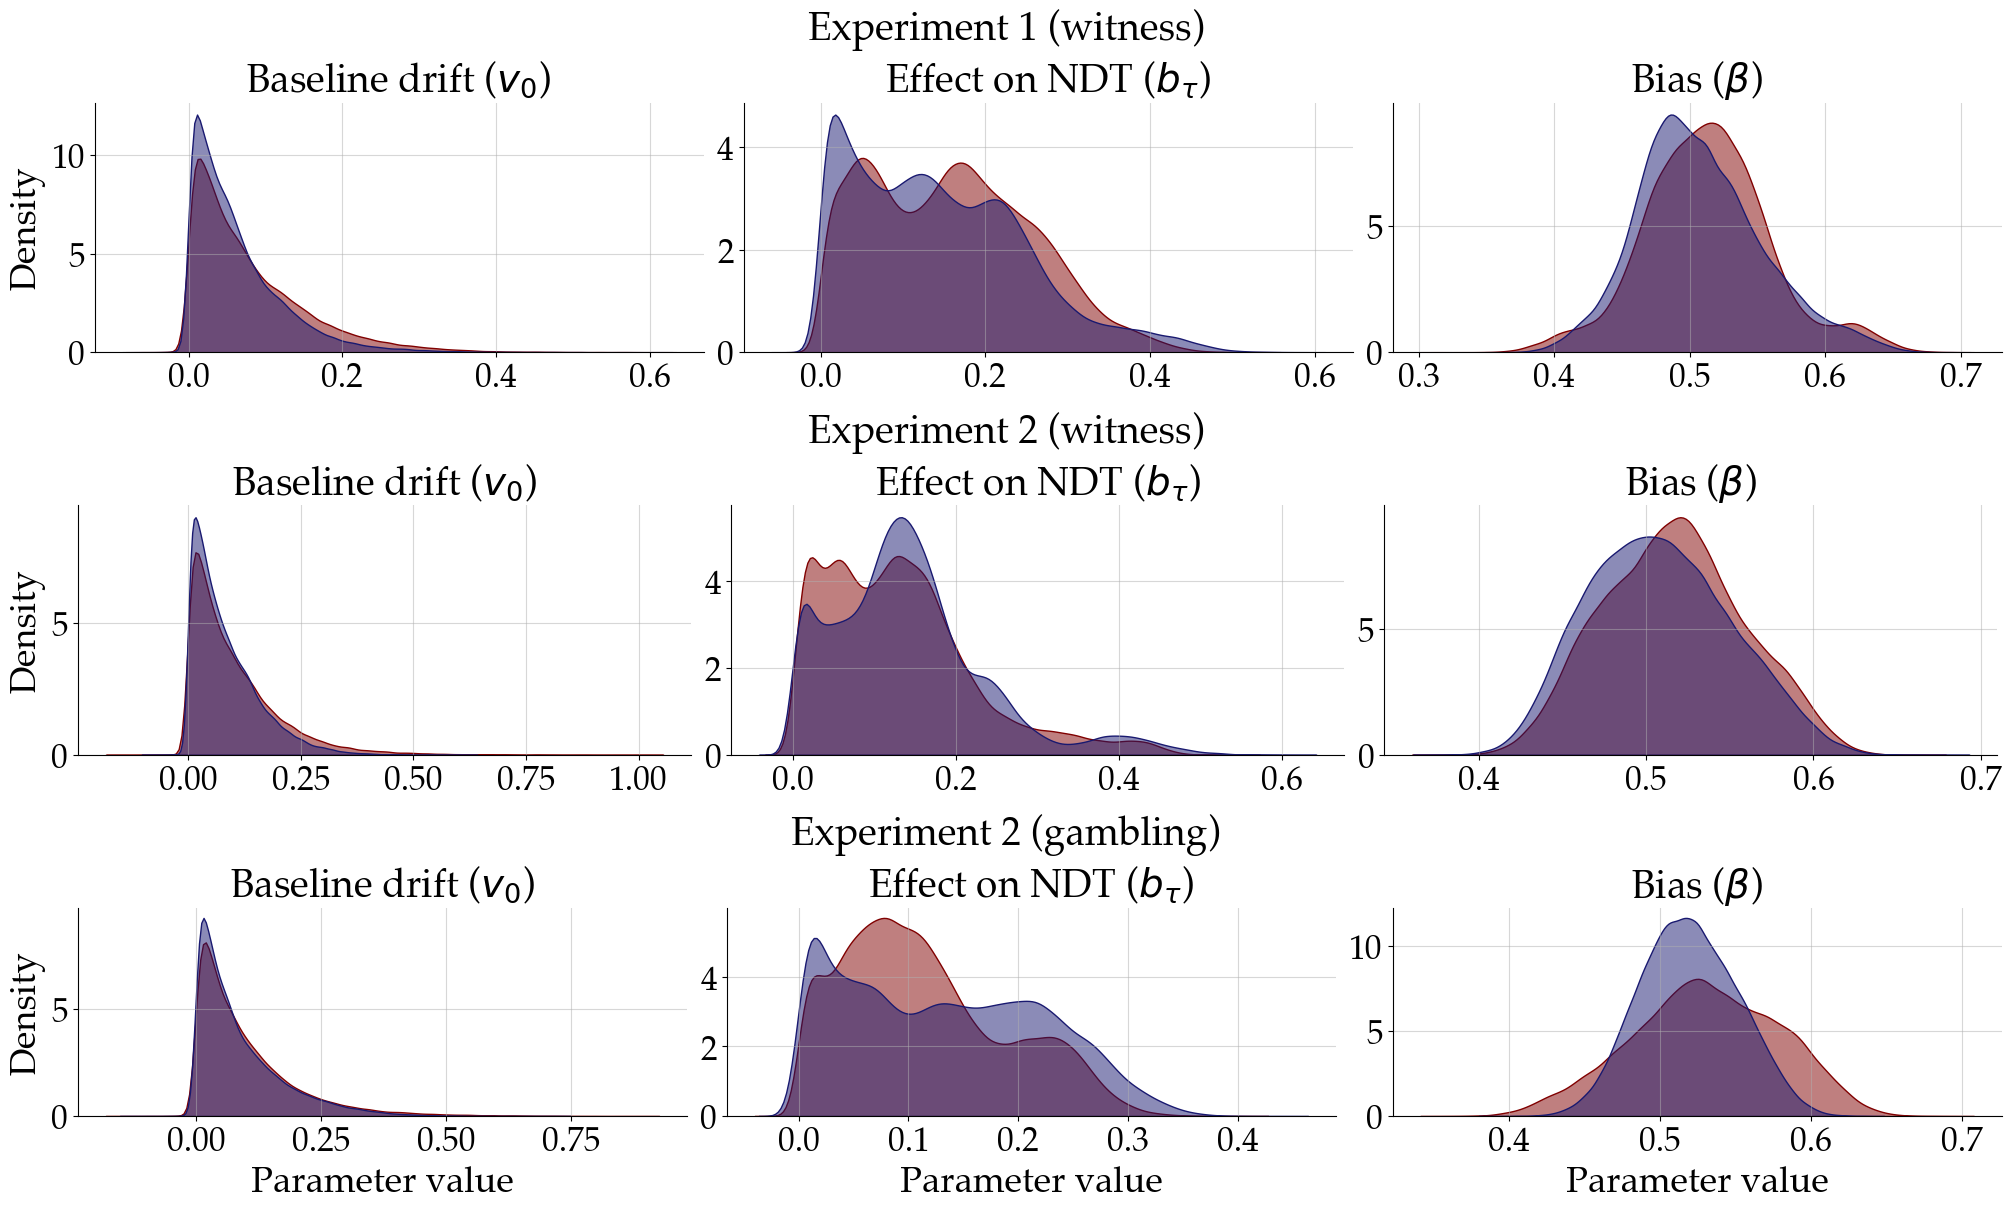

In [128]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
# create 4x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1, fontweight='bold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.kdeplot(
            shared_post_per_condition[2*row][:, :, col].flatten(),
            fill='maroon', alpha=0.5, ax=ax, color='maroon'
        )
        sns.kdeplot(
            shared_post_per_condition[2*row+1][:, :, col].flatten(),
            fill='midnightblue', alpha=0.5, ax=ax, color='midnightblue'
        )
        ax.grid(alpha=0.5)
        ax.set_title(f'{GLOBAL_PARAM_LABELS[col]} ({GLOBAL_PARAM_NAMES[col]})', fontsize=FONT_SIZE_1)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        if col == 0:
            ax.set_ylabel("Density", fontsize=FONT_SIZE_2)
        else:
            ax.set_ylabel("", fontsize=FONT_SIZE_2)
        if row == 2:
            ax.set_xlabel("Parameter value", fontsize=FONT_SIZE_2)

sns.despine()
fig.savefig("../plots/average_global_parameter.pdf", dpi=300, bbox_inches="tight")

## Posterior Re-simulation

In [46]:
emp_df_per_condition = []
for ids in ids_per_condition:
    emp_df_per_condition.append(
        data.loc[data["id"].isin(ids), ("condition", "id", "resp", "correct", "correct_resp", "number_faces", "validity", "rt")]
    )

In [55]:
pred_df_per_condition = []
for data in pred_data_per_condition:
    reshaped_data = data.reshape(-1, 7)
    resim_df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'resp', 'correct', 'number_faces', 'validity'])
    resim_df["correct"] = np.where(resim_df["resp"] == resim_df["correct"], 1, 0)
    pred_df_per_condition.append(resim_df)

In [62]:
pred_summaries_per_condition = []
for pred_data in pred_df_per_condition:
    grouped_data = pred_data.groupby(['id', 'validity'])
    resim_summaries = grouped_data.agg({
                'rt': ['median'],
                'correct': ['mean']
            }).reset_index(drop=False)
    resim_summaries.columns = ['id', "validity", 'rt_median', 'acc']

    grouped_data = resim_summaries.groupby(['validity'])
    resim_summaries = grouped_data.agg({
                'rt_median': ['mean', 'std'],
                'acc': ['mean', 'std']
            }).reset_index(drop=False)
    resim_summaries.columns = ["validity", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']
    pred_summaries_per_condition.append(resim_summaries)

In [59]:
emp_summaries_per_condition = []
for emp_df in emp_df_per_condition:
    grouped_data = emp_df.groupby(['id', 'validity'])
    empiric_summaries = grouped_data.agg({
                'rt': ['median'],
                'correct': ['mean']
            }).reset_index(drop=False)
    empiric_summaries.columns = ['id', "validity", 'rt_median', 'acc']

    grouped_data = empiric_summaries.groupby(['validity'])
    empiric_summaries = grouped_data.agg({
                'rt_median': ['mean', 'std'],
                'acc': ['mean', 'std']
            }).reset_index(drop=False)
    empiric_summaries.columns = ["validity", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']
    emp_summaries_per_condition.append(empiric_summaries)

In [105]:
summaries = [emp_summaries_per_condition, pred_summaries_per_condition]

ESCAPE = [-0.2, 0.2]
X_AXIS_VALUES = np.arange(8) * 1.5
COLOR = ['black', 'maroon']

LABELS = ["Empiric", "Re-simulated"]
SUBTITLES = ["Congruent", "Incongurent"]

## Response Times

/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_32850/62961144.py:35: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


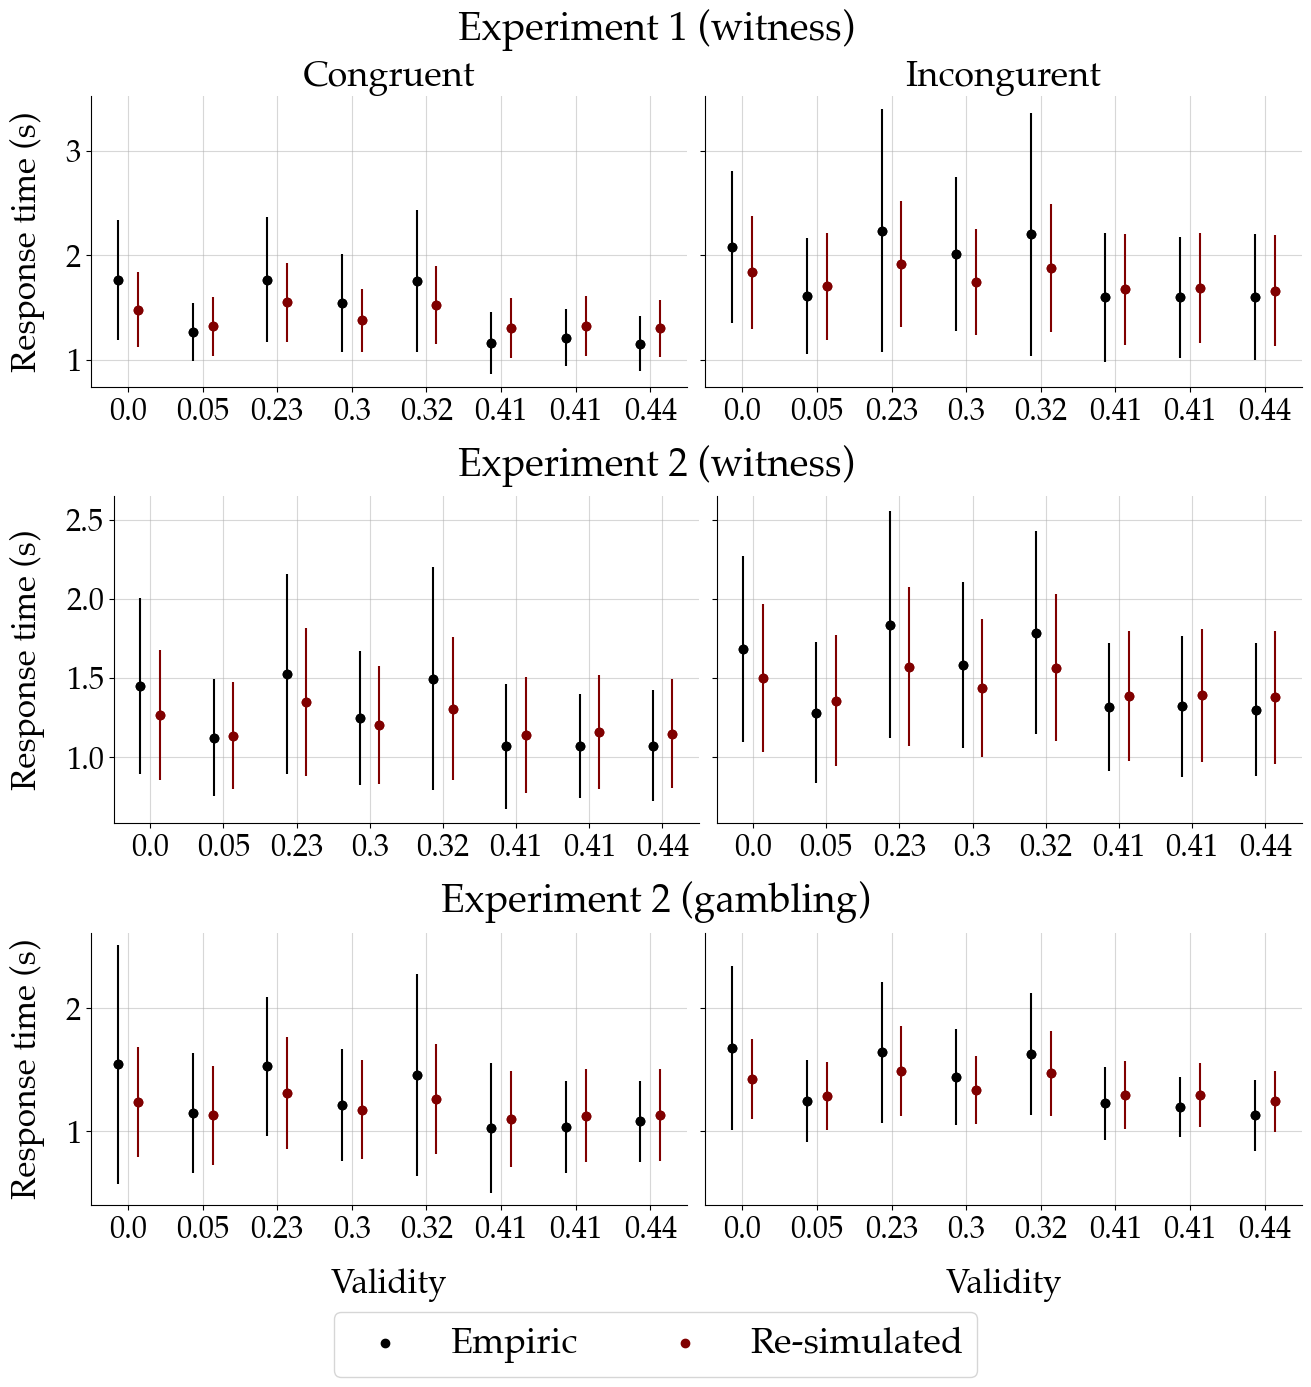

In [125]:
fig = plt.figure(constrained_layout=True, figsize=(13, 13))
# create 4x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1, fontweight='bold')
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
    for col, ax in enumerate(axs):
        for j in range(2):
            ax.scatter(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_rt_median'],
                color=COLOR[j], label=LABELS[j]
            )
            ax.errorbar(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_rt_median'],
                summaries[j][col+2*row]['std_rt_median'],
                fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
            )
            ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity'].unique().round(decimals=2))
        if row == 0:
            ax.set_title(f'{SUBTITLES[col]}', fontsize=FONT_SIZE_2)
        if row == 2:
            ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_3)
        if col == 0:
            ax.set_ylabel("Response time (s)", labelpad=15, fontsize=FONT_SIZE_3)
        if row == 0 and col == 0:
            fig.legend(
                fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.03),
                loc="center", ncol=2
            )
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
        ax.grid(alpha=0.5)
fig.subplots_adjust(hspace=0.5)

sns.despine()
fig.savefig("../plots/post_resim_rt.pdf", dpi=300, bbox_inches="tight")

## Accuracy

In [123]:
empiric_summaries['validity']

0    0.000
1    0.046
2    0.227
3    0.300
4    0.318
5    0.406
6    0.413
7    0.437
Name: validity, dtype: float64

/var/folders/9q/trrmd4jn4bx40rltjz_fmx4h0000gp/T/ipykernel_32850/3989315207.py:35: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


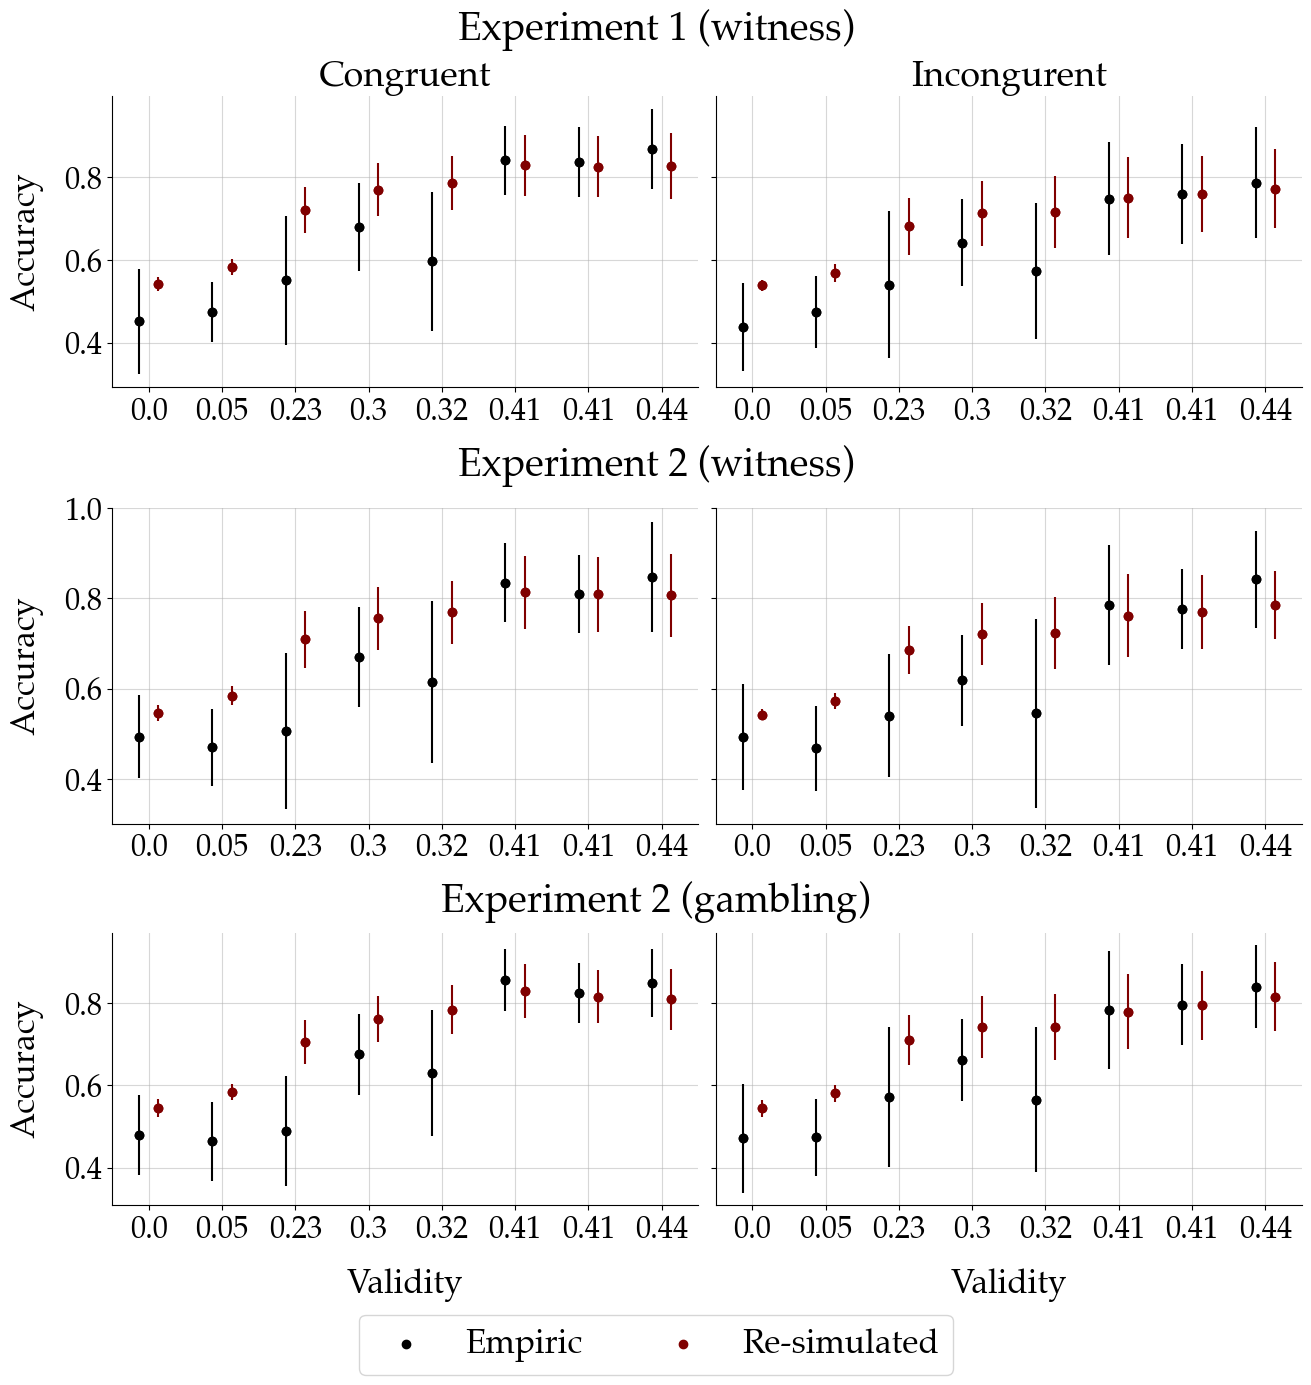

In [126]:
fig = plt.figure(constrained_layout=True, figsize=(13, 13))
# create 4x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(CONDITION_NAMES[row], fontsize=FONT_SIZE_1, fontweight='bold')
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
    for col, ax in enumerate(axs):
        for j in range(2):
            ax.scatter(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_acc'],
                color=COLOR[j], label=LABELS[j]
            )
            ax.errorbar(
                X_AXIS_VALUES + ESCAPE[j],
                summaries[j][col+2*row]['avg_acc'],
                summaries[j][col+2*row]['std_acc'],
                fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
            )
            ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity'].unique().round(decimals=2))
        if row == 0:
            ax.set_title(f'{SUBTITLES[col]}', fontsize=FONT_SIZE_2)
        if row == 2:
            ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_3)
        if col == 0:
            ax.set_ylabel("Accuracy", labelpad=15, fontsize=FONT_SIZE_3)
        if row == 0 and col == 0:
            fig.legend(
                fontsize=FONT_SIZE_3, bbox_to_anchor=(0.5, -0.03),
                loc="center", ncol=2
            )
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
        ax.grid(alpha=0.5)
fig.subplots_adjust(hspace=0.5)

sns.despine()
fig.savefig("../plots/post_resim_accuracy.pdf", dpi=300, bbox_inches="tight")